<a href="https://colab.research.google.com/github/Trantracy/CRNN-with-vietnamese-handwritten-detection/blob/master/CRNN_Vietnamese_Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline CRNN Model + CTC loss function

In [0]:
# This is the baseline to crack/solve the CAPTCHA image OCR problem without worrying about character segmentation.

# Things to improve for Hackathon:
# - Copy files into train and test folder from sample folder 1 and 2.
# - Handle labels with multiple json files.
# - Resize image logics with multiple image sizes (maybe as following):
#     + find min, max of height and width
#     + resize to a fixed height you want
#     + calculate the max width of all resized images
#     + padding to all images to that max width
# - Combine the logic of preprocessing of train set and test set together
# - Convert them to tfdataset pipeline (note that it is challenging since OpenCV won't work with tensor)
# - Rework/redesign new CRNN model to fit with your new processed images. 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json
import shutil
import matplotlib.pyplot as plt

# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2.1.0


In [0]:
# finding where we are so we dont need to type absolute path everytime
current_directory_path = pathlib.Path(".").absolute()
current_directory_path

PosixPath('/home/jupyter/vietnamese_handwritten/notebook')

In [0]:
# path to our directory images

# our train and test folder (not used for now but used later when we want to save images after processing)
DATA_PATH = os.path.join(str(current_directory_path),"..", "data")
TEST_FOLDER = os.path.join(DATA_PATH, "test")
TRAIN_FOLDER = os.path.join(DATA_PATH, "train")
MODEL_PATH = os.path.join(str(current_directory_path),"..", "model")

# our raw folders
RAW_TEST_FOLDER = os.path.join(DATA_PATH, "raw")

In [0]:
print(DATA_PATH)
print(TEST_FOLDER)
print(TRAIN_FOLDER)
print(MODEL_PATH)
print(RAW_TEST_FOLDER)

/home/jupyter/vietnamese_handwritten/notebook/../data
/home/jupyter/vietnamese_handwritten/notebook/../data/test
/home/jupyter/vietnamese_handwritten/notebook/../data/train
/home/jupyter/vietnamese_handwritten/notebook/../model
/home/jupyter/vietnamese_handwritten/notebook/../data/raw


In [0]:
# Constants (we choose this number as we later discover that the output of our CNN is (1,9,512) from out input)
TIME_STEPS = 270

In [0]:
# checking if GPU is available 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#!ls /home/jupyter/data/captcha/data/raw

## Read json label

In [0]:
# Import json file 1
with open('/home/jupyter/vietnamese_handwritten/data/raw/labels_1.json') as json_file:
    label_data_1 = json.load(json_file)
    
#Import Json file 2
with open('/home/jupyter/vietnamese_handwritten/data/raw/labels_2.json') as json_file:
    label_data_2 = json.load(json_file)

In [0]:
# print(label_data_1)
# print(label_data_2)

In [0]:
label_data_2['0179_samples.png']

'Thôn Vệ Sơn Đông, xã Tân Minh, Xã Tân Minh, Huyện Sóc Sơn, Hà Nội'

## Reading images and organise folders

In [0]:
#Remove .ipynb_checkpoints folder
raw_data_path = pathlib.Path(os.path.join(RAW_TEST_FOLDER,'data_unzip'))
for item in raw_data_path.glob('**/.ipynb_checkpoints'):
    os.chdir(item.parent)
    shutil.rmtree(str(item.name))
    print("Removed {}".format(item))
for item in raw_data_path.glob('**/*.v2'):
    os.chdir(item.parent)
    os.remove(str(item.name))
    print("Removed {}".format(item))

In [0]:
#Matching path and label for training va validation dataset
dict_file_label={}
raw_data_path = pathlib.Path(os.path.join(RAW_TEST_FOLDER,'data_unzip','0916_DataSamples2'))
char_list= set()
for item in raw_data_path.glob('**/*.*'):
    label = label_data_2[str(os.path.basename(item))]
    dict_file_label[str(item)]=label
    char_list.update(set(label))
char_list=sorted(char_list)
len(char_list)

139

In [0]:
#Matching path and label for test data set
test_dict_file_label={}
raw_data_path = pathlib.Path(os.path.join(RAW_TEST_FOLDER,'data_unzip','0825_DataSamples 1'))
for item in raw_data_path.glob('**/*.*'):
    label = label_data_1[str(os.path.basename(item))]
    test_dict_file_label[str(item)]=label

In [0]:
# checking the total alphabet characters of the whole dataset
# raw_data_path = pathlib.Path(RAW_TEST_FOLDER)
# char_list= set()
# dict_file_label={}
# for item in raw_data_path.glob('*'):
#     label = os.path.basename(os.path.splitext(item)[0])
#     dict_file_label[str(item)]=label
#     char_list.update(set((label)))
# char_list=sorted(char_list)

# print("Total number of characters : {}".format(len(char_list)))

In [0]:
#dict_file_label

In [0]:
# show all possible labels characters
"".join(char_list)

" #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"

In [0]:
# find the maximum label length
label_lens= []
for label in dict_file_label.values():
    label_lens.append(len(label))
max_label_len = max(label_lens)

In [0]:
# Only because this dataset is CAPTCHA so the length of all labels are 4.
max_label_len

69

In [0]:
# convert the words to array of indexs based on the char_list
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [0]:
# testing our encode function (text to number)
encode_to_labels("2345ABCDE") 

[12, 13, 14, 15, 21, 22, 23, 24, 25]

In [0]:
# all possible image paths for training
all_image_paths = list(dict_file_label.keys())
test_image_paths = list(test_dict_file_label.keys())

In [0]:
# all_image_paths

In [0]:
# test_image_paths

In [0]:
# find all widths and heights of images (this is useful if our dataset images got different sizes)
widths = []
heights = []
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    (height, width, _) = img.shape
    heights.append(height)
    widths.append(width)

In [0]:
min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)

The result is (24, 24, 72, 72) for this dataset so it is definitely telling us 
that we don't need to resize the image at all. 
But imagine if the result is (a,b,c,d). Then we should resize all images to the height of a or b
Then padding horizontally following the new max width of resized images

In this case, our images got the same size so no need to do anything at all

In [0]:
# this information is useful for making decision for padding and resizing
(min_height, max_height, min_width, max_width)

(94, 118, 1705, 1895)

In [0]:
# being a good Data Scientist, we need to have train set and test set
from sklearn.model_selection import train_test_split
test_size = 0.2
train_image_paths, val_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

## Preprocessing

In [0]:
# BUILD THE PIPELINE FOR THE IMAGES, definitely this is super basic pipeline and can be improved

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
resize_max_width=0
i=0
for train_img_path in train_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)
    
    height, width = img.shape

    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(118/height*width),118))
    
    height, width = img.shape
    
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]

    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    
    # YOUR PART: Blur it
    img = cv2.GaussianBlur(img, (5,5), 0)

    # YOUR PART: Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_file_label[train_img_path]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))
print(resize_max_width)

has processed trained 500 files
has processed trained 1000 files
2167


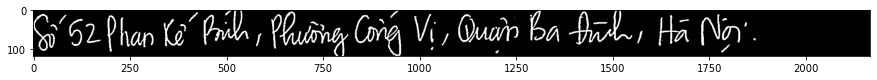

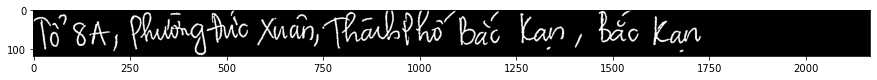

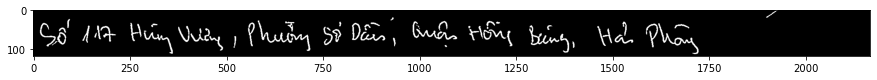

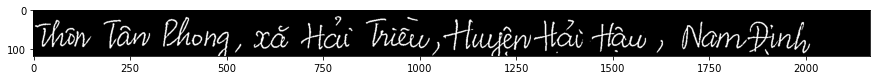

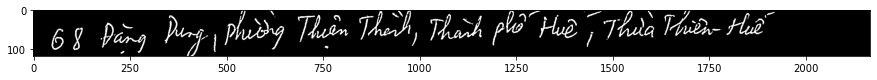

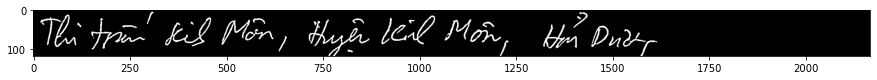

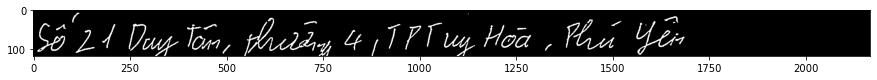

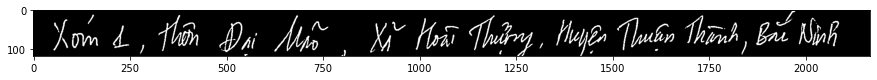

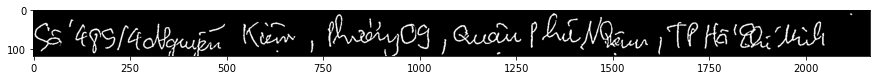

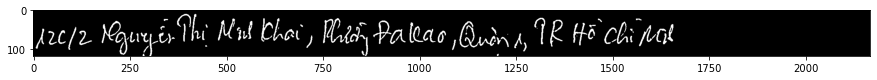

In [0]:
for i in range(10):
    plt.figure(figsize=(15,2))
    plt.imshow(training_img[i][:,:,0], cmap="gray")
    plt.show()

In [0]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for val_img_path in val_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(val_img_path), cv2.COLOR_BGR2GRAY)
    
    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(118/height*width),118))
    
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]
        
    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    
    # YOUR PART: Blur it
    img = cv2.GaussianBlur(img, (5,5), 0)

    # YOUR PART: Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_file_label[val_img_path]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))
print(resize_max_width)

2167


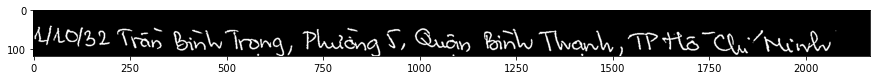

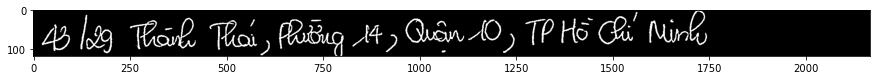

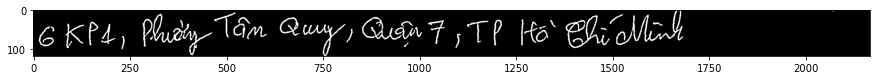

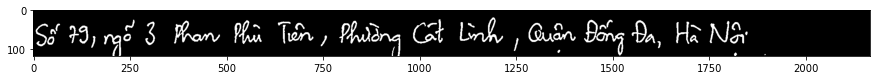

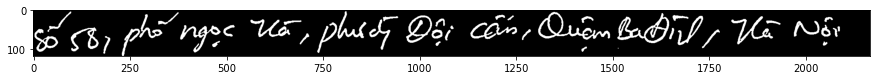

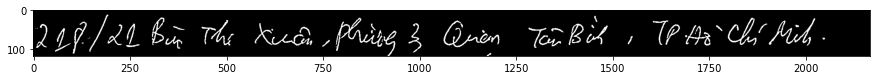

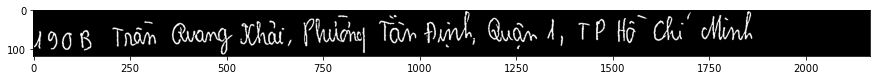

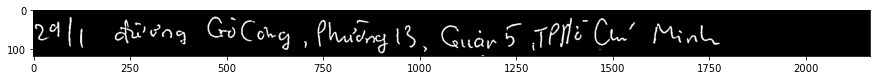

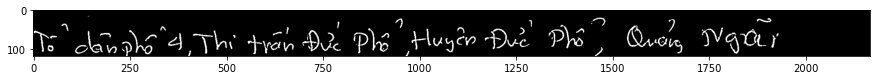

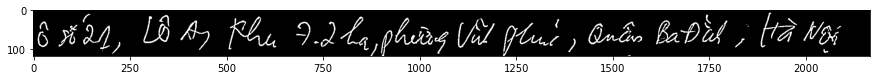

In [0]:
for i in range(10):
    plt.figure(figsize=(15,2))
    plt.imshow(valid_img[i][:,:,0], cmap="gray")
    plt.show()

In [0]:
# lists for testing dataset
testing_img = []
test_orig_txt = []
i=0
for test_img_path in test_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    
    height, width = img.shape
    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(118/height*width),118))
    
    height, width = img.shape
    
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]
        
    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    
    # YOUR PART: Blur it
    img = cv2.GaussianBlur(img, (5,5), 0)
    
    # YOUR PART: Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.
    
    label = test_dict_file_label[test_img_path]
    
    # split data into validation and training dataset as 10% and 90% respectively
    test_orig_txt.append(label)   
    
    # our time steps for valid input
    testing_img.append(img)
    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

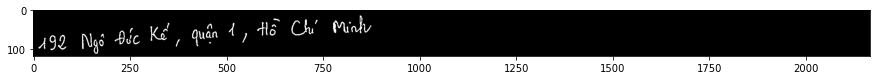

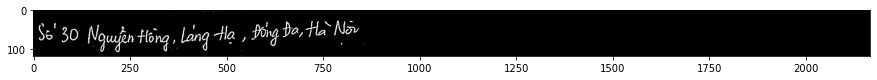

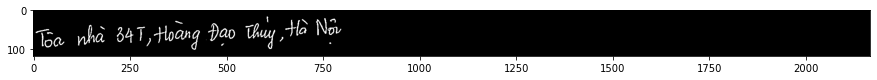

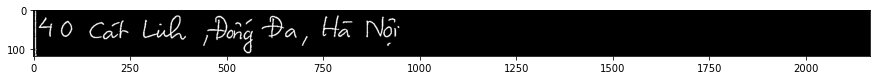

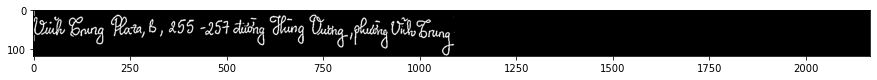

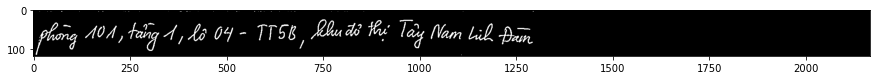

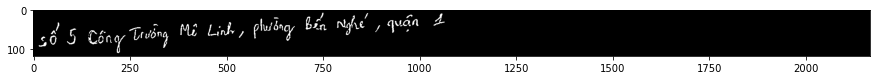

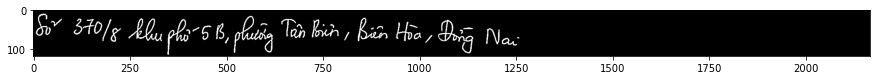

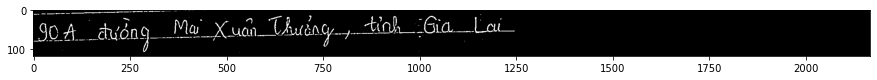

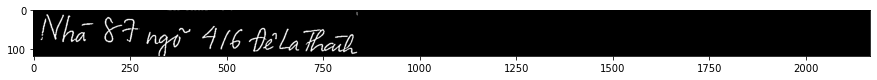

In [0]:
for i in range(10):
    plt.figure(figsize=(15,2))
    plt.imshow(testing_img[i][:,:,0], cmap="gray")
    plt.show()

In [0]:
# this is the most controversial part when our max_label_len should be set different or slightly smaller than TIME_STEPS
# but let stick to the conventional/normal way: we should to be the same with our TIME_STEPS
max_label_len = TIME_STEPS 

In [0]:
# pad each output label to maximum text length, remember we did that so that we keep training with rnn consistent?
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

In [0]:
train_padded_txt[0]

array([ 39, 117,   0,  15,  12,   0,  36,  52,  46,  57,   0,  31, 108,
         0,  22,  80,  57,  52,   6,   0,  36,  52,  95, 123,  57,  51,
         0,  23, 117,  57,  51,   0,  42, 114,   6,   0,  37,  64, 101,
        57,   0,  22,  46,   0,  89,  79,  57,  52,   6,   0,  28,  72,
         0,  34, 121,  53,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Model Building

In [0]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=32 and width=128 
inputs = Input(shape=(118,2167,1))
 
# convolution layer with kernel size (3,3)  #(24,72,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(12,36,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(12,36,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(6,18,128)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

#(6,18,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(3,9,256)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# poolig layer with kernel size (2,2) to make the height/2  #(3,9,256)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

# Batch normalization layer #3,9,256)
batch_norm_5 = BatchNormalization()(pool_4)

#(3,9,512)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)

# poolig layer with kernel size (2,2) to make the height/2 #(1,9,512)
pool_6 = MaxPool2D(pool_size=(2, 1))(conv_6)

batch_norm_6 = BatchNormalization()(pool_6)

# poolig layer with kernel size (2,2) to make the height/2 #(1,9,512)
pool_7 = MaxPool2D(pool_size=(3, 1))(batch_norm_6)
 
# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_7)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

In [0]:
act_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 118, 2167, 1)]    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 118, 2167, 64)     640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 1083, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 59, 1083, 128)     73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 541, 128)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 541, 256)      295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 270, 256)      0   

In [0]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [0]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH,'checkpoint_weights.hdf5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
#     EarlyStopping(
#         monitor='val_loss',
#         min_delta=1e-8,
#         patience=20,
#         restore_best_weights=True,
#         verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 118, 2167, 1 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 118, 2167, 64 640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 59, 1083, 64) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 59, 1083, 128 73856       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [0]:
# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our validating data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

# ready our testing data
testing_img = np.array(testing_img)

## Model Training

 **Yann LeCun** said:
"Training with large minibatches is bad for your health.
 More importantly, it's bad for your test error.
 Friends dont let friends use minibatches larger than 32."

In [0]:
# choose batchsize and epochs

batch_size = 32
epochs = 100

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Train on 1458 samples, validate on 365 samples
Epoch 1/100
1440/1458 [============================>.] - ETA: 0s - loss: 241.7119
Epoch 00001: val_loss improved from inf to 200.73223, saving model to /home/jupyter/vietnamese_handwritten/notebook/../model/checkpoint_weights.hdf5
1458/1458 [==============================] - 25s 17ms/sample - loss: 241.3135 - val_loss: 200.7322
Epoch 2/100
1440/1458 [============================>.] - ETA: 0s - loss: 199.6961
Epoch 00002: val_loss did not improve from 200.73223
1458/1458 [==============================] - 19s 13ms/sample - loss: 199.6163 - val_loss: 217.2618
Epoch 3/100
1440/1458 [============================>.] - ETA: 0s - loss: 185.8953
Epoch 00003: val_loss did not improve from 200.73223
1458/1458 [==============================] - 19s 13ms/sample - loss: 185.6682 - val_loss: 232.8292
Epoch 4/100
1440/1458 [============================>.] - ETA: 0s - loss: 142.6368
Epoch 00004: val_loss did not improve from 200.73223
1458/1458 [=========

In [0]:
# save our model
model.save(os.path.join(MODEL_PATH,'lastest_model.h5'))

## Decode and Prediction

In [0]:
# load the saved best model weights
act_model.load_weights(os.path.join(MODEL_PATH,'checkpoint_weights.hdf5'))

In [0]:
# predict outputs on validation images
NO_PREDICTS = 10
OFFSET=0
# prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
prediction = act_model.predict(valid_img)

In [0]:
# NO_PREDICTS image results
# 9 timesteps
# 32 chars + 1 blank
prediction.shape

(365, 270, 140)

In [0]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  1/10/32 Trần Bình Trọng, Phường 5, Quận Bình Thạnh, TP Hồ Chí Minh
predicted text = 110/32 Trần Bình Trọng, Phường 5, Quận Bình Thạnh, TP Hồ Chí Minh
original_text  =  43/29 Thành Thái, Phường 14, Quận 10, TP Hồ Chí Minh
predicted text = 4/L9 Thành Thái, Phường 14, Quận 10, TP Hồ Chí Minh
original_text  =  6 KP1, Phường Tân Quy, Quận 7, TP Hồ Chí Minh
predicted text = 6 KP1, Phường Tân Quy, Quận 7, TP Hồ Chí Ninh
original_text  =  Số 79, ngõ 3 Phan Phù Tiên, Phường Cát Linh, Quận Đống Đa, Hà Nội
predicted text = Số 79, ngõ 3 Phan Phù Tiên, Phường Cát Linh, Quận Đống Đa, Hà Nội
original_text  =  Số 58, phố Ngọc Hà, Phường Đội Cấn, Quận Ba Đình, Hà Nội
predicted text = Số 58, phố ngọc Hã, Phườnh Đội Cẩm, Quận Ba Đình, Hà Nội
original_text  =  218/21 Bùi Thị Xuân, Phường 3, Quận Tân Bình, TP Hồ Chí Minh
predicted text = 21P/21 Bùn Thị Xuân, Phường 3, Quận Tâ Bình, TP H Chí Minh
original_text  =  190B Trần Quang Khải, Phường Tân Định, Quận 1, TP Hồ Chí Minh
predicted text

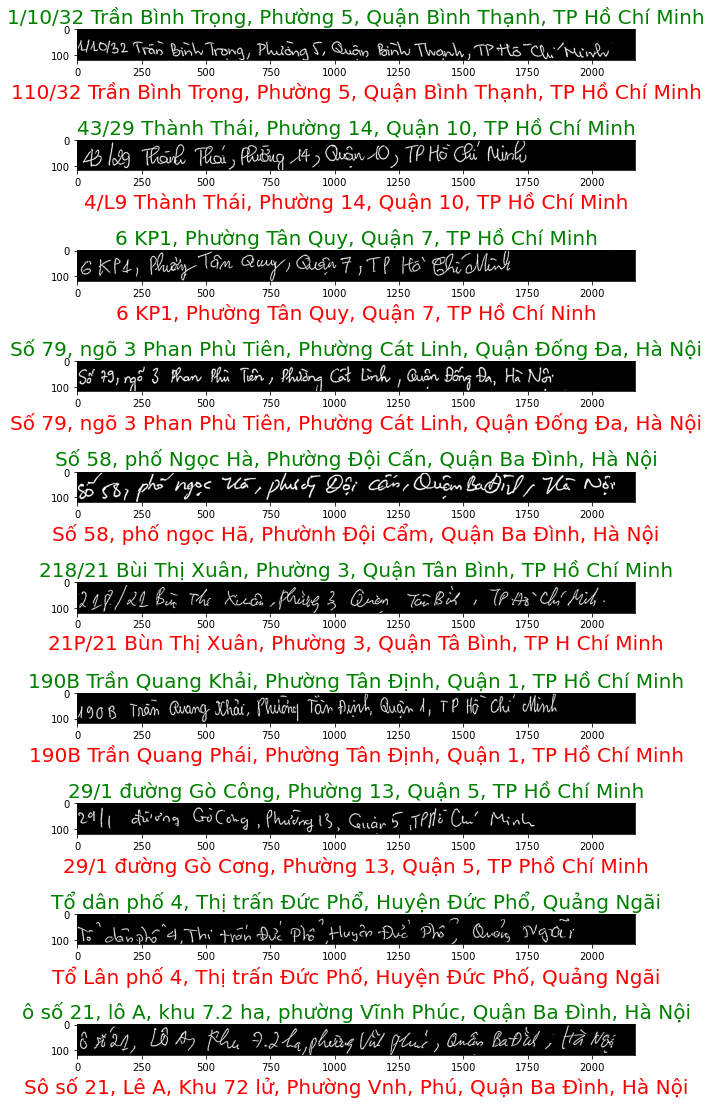

In [0]:
#YOUR PART: WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,20))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)
# gs1.update(wspace=0.025, hspace=0.025)
for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.title(valid_orig_txt[n+OFFSET], fontsize=20, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel(all_predictions[n+OFFSET], fontsize=20, color="red")


## Evaluation using CER, WER and SER

Tool to metrics calculation through data and label (string and string).
 * Calculation from Optical Character Recognition (OCR) metrics with editdistance.
This is borrowed from https://github.com/arthurflor23/handwritten-text-recognition/blob/master/src/data/evaluation.py

It is not needed to understand this function deeply, it only helps to calculate three evaluation metris:
- CER (Character Error Rate)
- WER (Word Error Rate)
- SER (Sequence Error Rate)

In [0]:
!pip install editdistance

In [0]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [0]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

This is a easy dataset so I got perfect score for absolutely the test set! Not even a challenge for CRNN power!

In [0]:
print(e_corpus)

Metrics:
Character Error Rate: 0.044268671657498065
Word Error Rate:      0.15795132256050892
Sequence Error Rate:  0.7890410958904109


In [0]:
# So what do we learn from here:
# - CRNN + CTC is not that challenging, just want sure we follow above process step by step
# - Keep our height and width is a power of 2 or at least even number is making our time much 
# easier to divide by half (it is not really important, since it is related to design your model and preprocessing)
# - The number bi LSTM paramater is larger the number of timestep since our biLSTM /2 will be at least the size of hidden node for each single LSTM.
# - The max label length should be the same to the number of time steps, but some people report if they set it to be slightly lower than time step, it helps. 
# But you should stick with the basics!
# - The data is super clean and same image dimension. So for other datasets, maybe a bit of noise cleaning and binarization may help!
